<a href="https://colab.research.google.com/github/coraline1111/UTS-Group-Project/blob/main/Group_Project_Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libiary and files

In [1]:
# Import libraries
import pandas as pd
import os
import warnings
import folium
import geopandas as gpd
from shapely.geometry import Point
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans, DBSCAN
import plotly.express as px
import plotly.subplots as sp
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Read a CSV file named '2016Q1' from the folder
file_path = '/content/drive/My Drive/Group Project/Dataset/2016Q1.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,166,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,11th & Kenyon St NW,31105,14th & Harvard St NW,W01346,Member
1,448,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,Old Georgetown Rd & Southwick St,32002,Bethesda Ave & Arlington Rd,W22202,Member
2,715,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,New York Ave & 15th St NW,31214,17th & Corcoran St NW,W21427,Member
3,213,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,1st & Rhode Island Ave NW,31509,New Jersey Ave & R St NW,W01294,Member
4,872,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,Prince St & Union St,31048,King St Metro South,W22058,Member


In [3]:
# get the folder path
folder_path = '/content/drive/My Drive/Group Project/Dataset'
# list csv files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print(csv_files)

# merge all csv (they have the same column names)
combined_df = pd.concat(
    [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files],
    ignore_index=True
)
combined_df.head()
combined_df.tail()

['2016Q1.csv', '2016Q2.csv', '2016Q3.csv', '2016Q4.csv', '2017Q1.csv', '2017Q2.csv', '2017Q3.csv', '2017Q4.csv', '201801.csv', '201802.csv', '201803.csv', '201804.csv', '201805.csv', '201806.csv', '201807.csv', '201808.csv', '201809.csv', '201810.csv', '201811.csv', '201812.csv']


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
10634450,3313,2018-12-31 23:37:22,2019-01-01 00:32:36,31615,6th & H St NE,31624,North Capitol St & F St NW,W00159,Member
10634451,888,2018-12-31 23:42:18,2018-12-31 23:57:07,31618,4th & East Capitol St NE,31509,New Jersey Ave & R St NW,W22026,Member
10634452,2332,2018-12-31 23:44:23,2019-01-01 00:23:16,31907,Franklin & S Washington St,32406,Fleet St & Waterfront St,W23900,Member
10634453,307,2018-12-31 23:52:42,2018-12-31 23:57:50,31114,18th St & Wyoming Ave NW,31103,16th & Harvard St NW,W00761,Member
10634454,1062,2018-12-31 23:54:09,2019-01-01 00:11:52,31110,20th St & Florida Ave NW,31014,Lynn & 19th St North,W21324,Member


## EDA of Combined CSV file

In [4]:
print (combined_df.columns)

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')


### Checking and removing duplicates


In [5]:
# Check for duplicate rows
duplicate_rows = combined_df[combined_df.duplicated()]

# Count the number of duplicates
num_duplicates = len(duplicate_rows)
print(f"Total duplicate rows: {num_duplicates}")

# If duplicates exist, save them as a CSV file
if num_duplicates > 0:
    duplicate_csv_path = "/content/duplicate_rows.csv"
    duplicate_rows.to_csv(duplicate_csv_path, index=False)
    print(f"Duplicate rows saved to {duplicate_csv_path}")
else:
    print("No duplicate rows found.")


Total duplicate rows: 18441
Duplicate rows saved to /content/duplicate_rows.csv


In [6]:
from google.colab import files
files.download("/content/duplicate_rows.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Even though the code shows there are duplicates, after mannually checking in the csv files, it seems like the trip details were too similar so they were mistaken as duplicates. There is no deplicates in the csv files.

In [7]:
df= combined_df

# Basic info about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Check unique values in categorical columns
print(df['Member type'].unique())
print(df['Bike number'].nunique())  # Unique bikes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634455 entries, 0 to 10634454
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Duration              int64 
 1   Start date            object
 2   End date              object
 3   Start station number  int64 
 4   Start station         object
 5   End station number    int64 
 6   End station           object
 7   Bike number           object
 8   Member type           object
dtypes: int64(3), object(6)
memory usage: 730.2+ MB
None
Duration                0
Start date              0
End date                0
Start station number    0
Start station           0
End station number      0
End station             0
Bike number             0
Member type             0
dtype: int64
           Duration  Start station number  End station number
count  1.063446e+07          1.063446e+07        1.063446e+07
mean   1.148938e+03          3.131844e+04        3.131927e+04
std    2.255886e+03   

## Date Time Conversion

Takes the datetime information from the 'Start date' column and breaks it down into separate columns for year, month, day, hour, and the day of the week

In [8]:
# Convert Start date and End date columns to datetime format
combined_df['Start date'] = pd.to_datetime(combined_df['Start date'], format='%Y-%m-%d %H:%M:%S')
combined_df['End date'] = pd.to_datetime(combined_df['End date'], format='%Y-%m-%d %H:%M:%S')

# Verify the conversion
print(combined_df.dtypes)
print(combined_df[['Start date', 'End date']].head())


Duration                         int64
Start date              datetime64[ns]
End date                datetime64[ns]
Start station number             int64
Start station                   object
End station number               int64
End station                     object
Bike number                     object
Member type                     object
dtype: object
           Start date            End date
0 2016-01-01 00:06:58 2016-01-01 00:09:44
1 2016-01-01 00:10:20 2016-01-01 00:17:48
2 2016-01-01 00:13:52 2016-01-01 00:25:48
3 2016-01-01 00:15:29 2016-01-01 00:19:03
4 2016-01-01 00:16:16 2016-01-01 00:30:49


## Daily Rides Over Time

Summarizing the number of rides that occur each day and then creating a time series plot to visualize how the number of rides changes over time

In [10]:
df['Year'] = df['Start date'].dt.year
df['Month'] = df['Start date'].dt.month
df['Day'] = df['Start date'].dt.day
df['Hour'] = df['Start date'].dt.hour
df['DayOfWeek'] = df['Start date'].dt.dayofweek  # Monday=0, Sunday=6


<Axes: title={'center': 'Daily Rides Over Time'}, xlabel='Start date'>

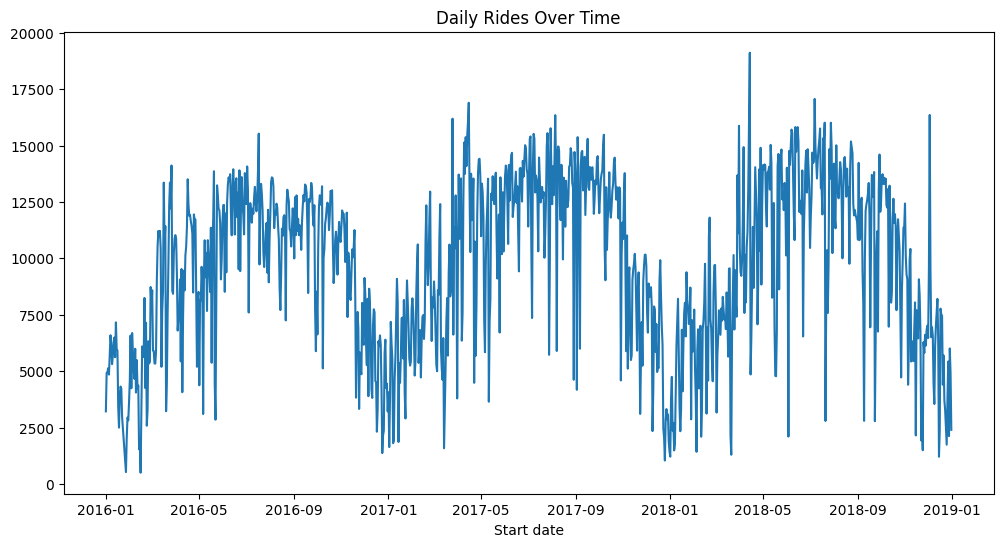

In [11]:
# Daily rides
daily_rides = df.groupby(df['Start date'].dt.date).size()

# Plot daily rides
daily_rides.plot(title='Daily Rides Over Time', figsize=(12, 6))


From 2016 to 2018, the number of rides generally followed a pattern. The rides increased from January to around May, and then there was a decline after October.

## Memeber vs Non Member Usage

Comparing the usage trends of members versus non-members over time

<ipython-input-12-a60bf8609453>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  member_trends = df.groupby([df['Start date'].dt.date, 'Member type']).size().unstack()


<Axes: title={'center': 'Member vs. Non-Member Usage Over Time'}, xlabel='Start date'>

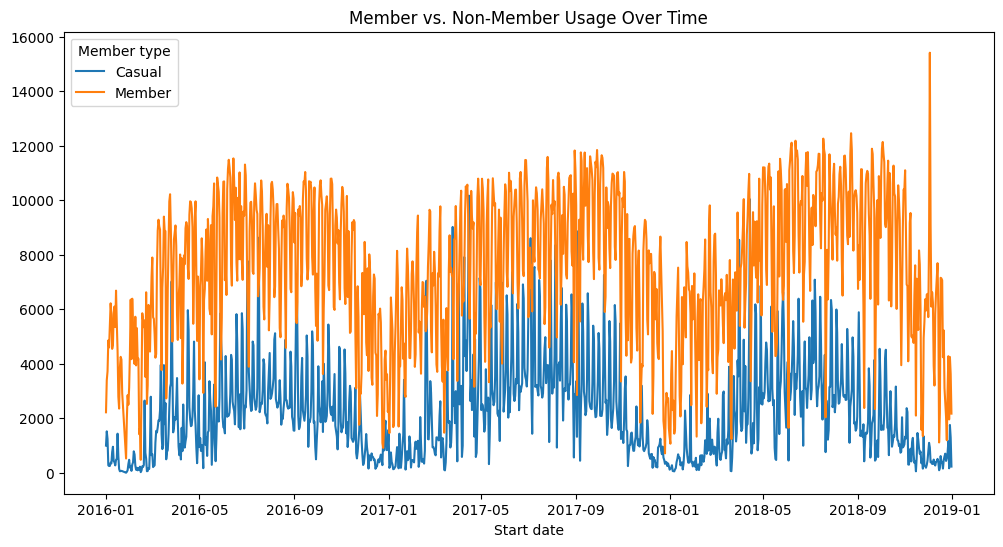

In [12]:
# Member type trends over time
df['Member type'] = df['Member type'].astype('category')
member_trends = df.groupby([df['Start date'].dt.date, 'Member type']).size().unstack()

# Plot member vs. casual trends
member_trends.plot(title='Member vs. Non-Member Usage Over Time', figsize=(12, 6))


Non members have less usage than members in general

## Stations Breakdown

Identifying the most popular start and end stations in the dataset

Top Start Stations:
 Start station
Columbus Circle / Union Station                          201905
Lincoln Memorial                                         179952
Jefferson Dr & 14th St SW                                159034
Massachusetts Ave & Dupont Circle NW                     138180
15th & P St NW                                           124225
Jefferson Memorial                                       113649
Smithsonian-National Mall / Jefferson Dr & 12th St SW    109738
Henry Bacon Dr & Lincoln Memorial Circle NW              103148
4th St & Madison Dr NW                                    97902
Thomas Circle                                             97233
Name: count, dtype: int64
Top End Stations:
 End station
Columbus Circle / Union Station                          213518
Lincoln Memorial                                         181351
Jefferson Dr & 14th St SW                                164225
Massachusetts Ave & Dupont Circle NW                     152495
15th & P St 

<Axes: title={'center': 'Top 10 Start Stations'}, xlabel='Start station'>

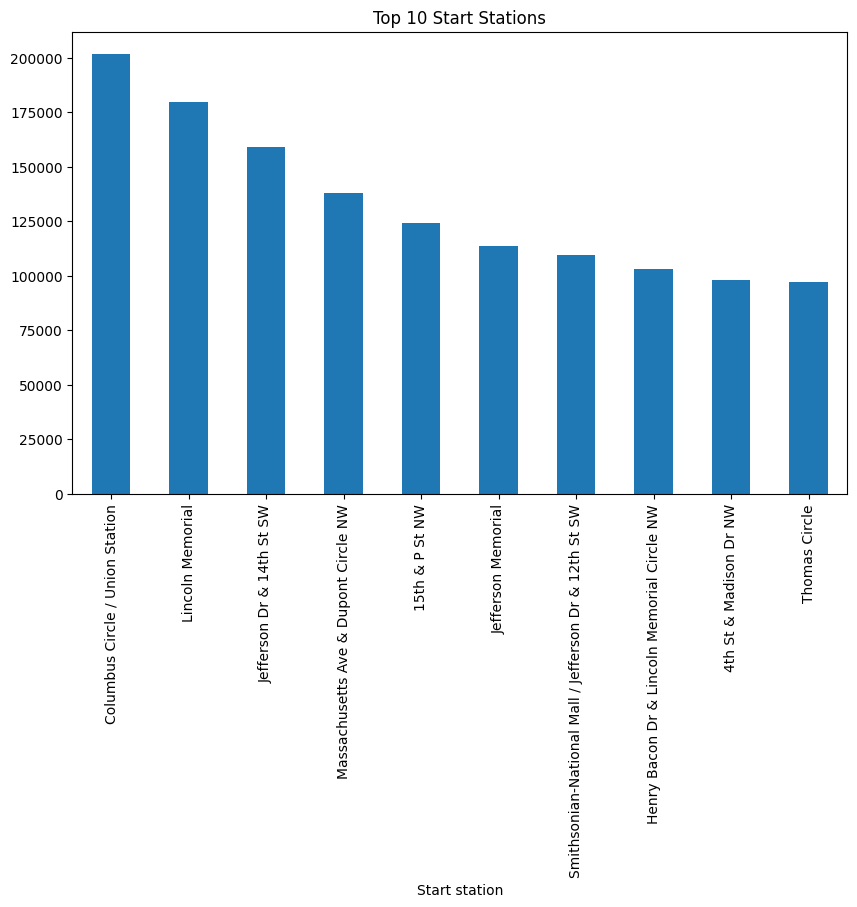

In [13]:
# Top start stations
top_start_stations = df['Start station'].value_counts().head(10)
top_end_stations = df['End station'].value_counts().head(10)

print("Top Start Stations:\n", top_start_stations)
print("Top End Stations:\n", top_end_stations)

# Visualize top stations
top_start_stations.plot(kind='bar', title='Top 10 Start Stations', figsize=(10, 6))


Columbus Cricle/Union Station is the most popular.

## Trip Duration

Calculates the duration of each trip in minutes

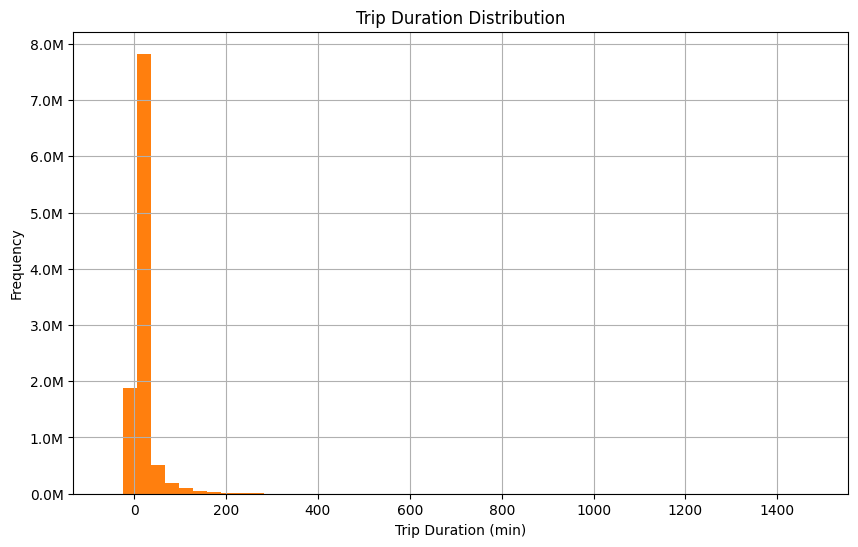

The highest trip duration frequency is: 7823569.0
The second highest trip duration frequency is: 1883781.0
The third highest trip duration frequency is: 504565.0


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Calculate trip duration in minutes
df['Trip Duration (min)'] = (df['End date'] - df['Start date']).dt.total_seconds() / 60

# Plot distribution with labels and formatted y-axis
ax = df['Trip Duration (min)'].plot(kind='hist', bins=50, title='Trip Duration Distribution', figsize=(10, 6))
ax.set_xlabel('Trip Duration (min)')
ax.set_ylabel('Frequency')
ax.grid(True)

# Get the histogram data
n, bins, patches = ax.hist(df['Trip Duration (min)'], bins=50)

# Find the highest, second highest, and third highest frequencies
sorted_frequencies = sorted(n, reverse=True)
highest_frequency = sorted_frequencies[0]
second_highest_frequency = sorted_frequencies[1]
third_highest_frequency = sorted_frequencies[2]

# Define a formatter function
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

# Format y-axis
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

plt.show()

print("The highest trip duration frequency is:", highest_frequency)
print("The second highest trip duration frequency is:", second_highest_frequency)
print("The third highest trip duration frequency is:", third_highest_frequency)


## Usage by Hour and Day of Week Analysis

Creating a heatmap that shows the usage intensity of rides based on the hour of the day and the day of the week.

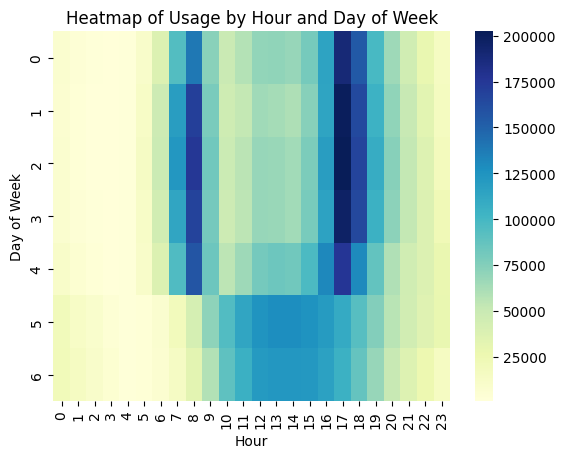

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

hourly_usage = df.groupby(['DayOfWeek', 'Hour']).size().unstack()
sns.heatmap(hourly_usage, cmap='YlGnBu')
plt.title('Heatmap of Usage by Hour and Day of Week')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.show()


Peak hours for weekdays is between 7-9 am and 5-7pm.
Peak hours for weekends is between 12-15pm.

## Seasonal Decomposition

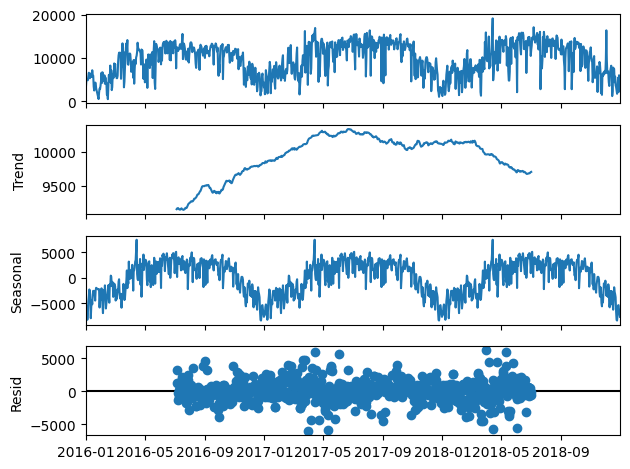

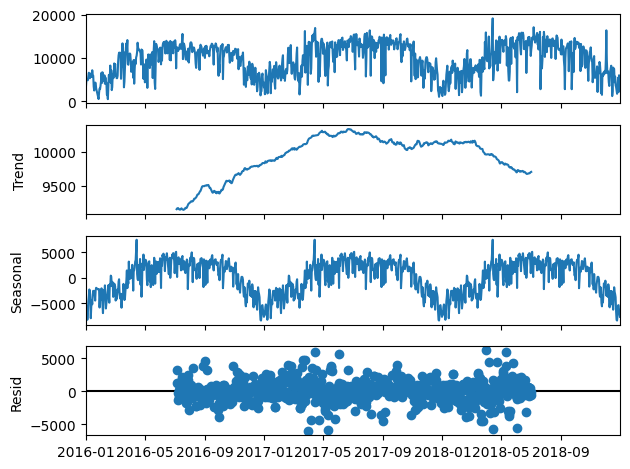

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use daily rides for decomposition
daily_rides.index = pd.to_datetime(daily_rides.index)
decompose = seasonal_decompose(daily_rides, model='additive', period=365)
decompose.plot()


The trend increases at the beginning of the year, stabilizes mid-year, and then decreases towards the end of the year. Since the dataset covers station from mainly the U.S., the pattern is likely influenced by seasonal factors such as weather and temperature.

## Dataset Date Range Verfication

In [17]:
print(combined_df.shape)  # Check the number of rows and columns
print(combined_df['Start date'].min(), combined_df['Start date'].max())  # Verify the date range


(10634455, 15)
2016-01-01 00:06:58 2018-12-31 23:54:09


## Correlation Matrix

Correlation Matrix:
           Duration      Hour  DayOfWeek
Duration   1.000000  0.017097   0.075220
Hour       0.017097  1.000000  -0.001785
DayOfWeek  0.075220 -0.001785   1.000000


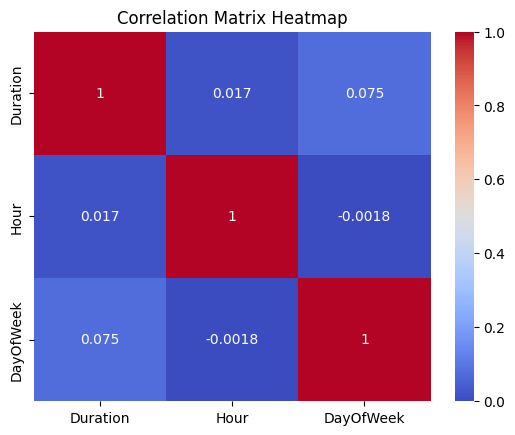

In [18]:
# Calculate the correlation matrix
correlation_matrix = combined_df[['Duration', 'Hour', 'DayOfWeek']].corr()

# Print the correlation matrix values
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


<Axes: >

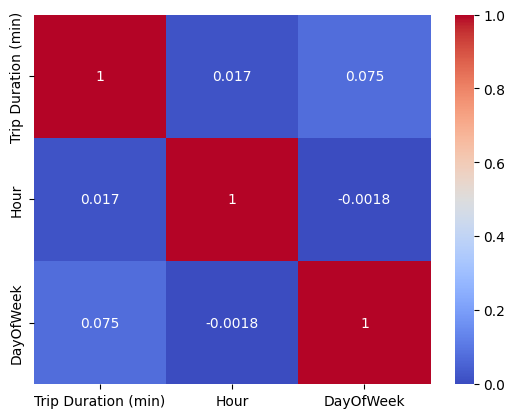

In [19]:
correlation_matrix = df[['Trip Duration (min)', 'Hour', 'DayOfWeek']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


In [20]:
# Extract the unique years from the 'Start date' column
df['Start date'] = pd.to_datetime(df['Start date'])  # Ensure datetime format
unique_years = df['Start date'].dt.year.unique()

# Count the number of years
print(f"Years covered in the dataset: {sorted(unique_years)}")
print(f"Number of years covered: {len(unique_years)}")


Years covered in the dataset: [2016, 2017, 2018]
Number of years covered: 3


## Statistical Measure


Descriptive Statistics:
                          Start date       Duration           Hour  \
count                         151060  151060.000000  151060.000000   
mean   2017-07-07 12:22:32.530120704    1087.081217      11.839878   
min              2016-01-01 00:00:00      60.000000       0.000000   
25%              2016-10-06 23:37:30     670.206897       6.000000   
50%              2017-07-09 07:45:00     898.400377      12.000000   
75%              2018-04-07 09:52:30    1281.678847      18.000000   
max              2018-12-31 23:50:00   67363.000000      23.000000   
std                              NaN    1030.397004       6.836880   

              Minute      DayOfWeek      IsWeekend  Start station number  \
count  151060.000000  151060.000000  151060.000000         151060.000000   
mean       25.500165       3.025626       0.290865          31314.368291   
min         0.000000       0.000000       0.000000          31000.000000   
25%        10.000000       1.000000     

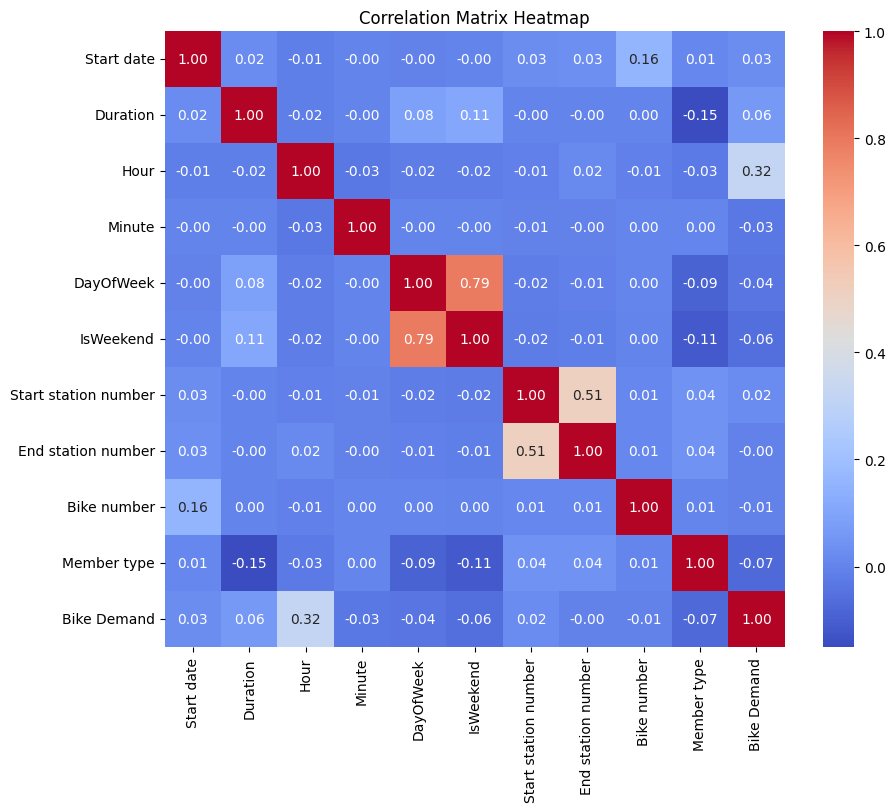

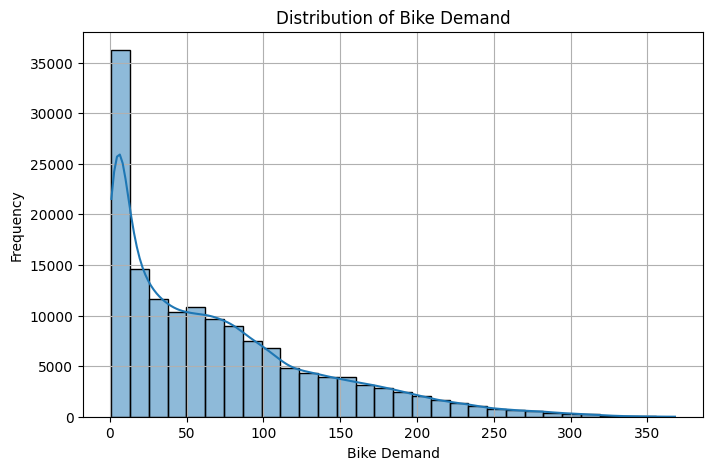

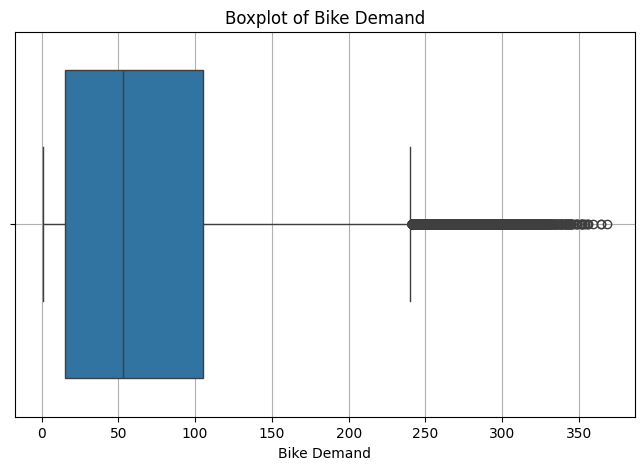

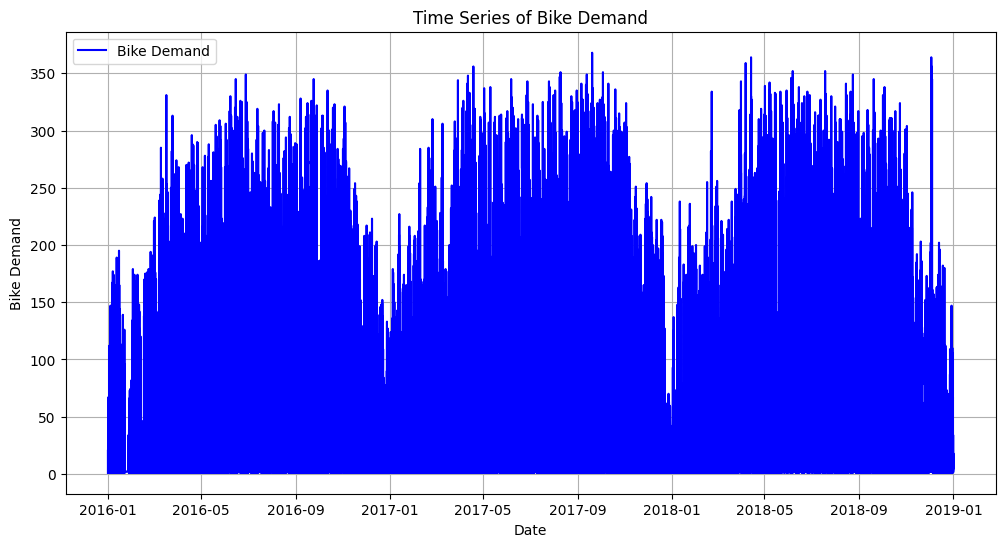


T-Test Results: t-statistic = 22.527870564936528, p-value = 3.392388353970301e-112
The difference in bike demand between weekdays and weekends is statistically significant.


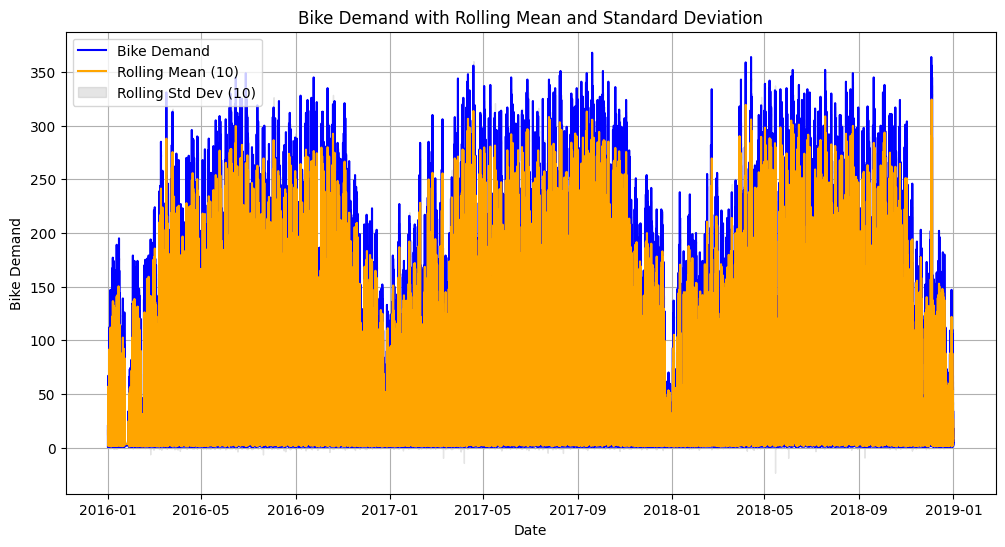

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing

# Convert 'Start date' to datetime
combined_df['Start date'] = pd.to_datetime(combined_df['Start date'])

# Set 'Start date' as the index for resampling
combined_df.set_index('Start date', inplace=True)

# Feature Engineering
combined_df['Hour'] = combined_df.index.hour
combined_df['Minute'] = combined_df.index.minute
combined_df['DayOfWeek'] = combined_df.index.dayofweek
combined_df['IsWeekend'] = combined_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating data per 10-minute intervals
bike_demand_per_10min = combined_df.resample('10T').agg({
    'Duration': 'mean',
    'Hour': 'first',
    'Minute': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Start station number': 'first',
    'End station number': 'first',
    'Bike number': 'first',
    'Member type': 'first'
}).reset_index()

bike_demand_per_10min['Bike Demand'] = combined_df['Bike number'].resample('10T').count().reset_index(drop=True)

# Encoding categorical features
label_encoder = LabelEncoder()
bike_demand_per_10min['Bike number'] = label_encoder.fit_transform(bike_demand_per_10min['Bike number'].astype(str))
bike_demand_per_10min['Member type'] = label_encoder.fit_transform(bike_demand_per_10min['Member type'].astype(str))

# Drop rows with missing values
bike_demand_per_10min.dropna(inplace=True)

# 2. Descriptive Statistics
print("\nDescriptive Statistics:")
print(bike_demand_per_10min.describe())

# 3. Correlation Matrix
correlation_matrix = bike_demand_per_10min.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# 4. Distribution Analysis
plt.figure(figsize=(8, 5))
sns.histplot(bike_demand_per_10min['Bike Demand'], kde=True, bins=30)
plt.title("Distribution of Bike Demand")
plt.xlabel("Bike Demand")
plt.ylabel("Frequency")
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=bike_demand_per_10min['Bike Demand'])
plt.title("Boxplot of Bike Demand")
plt.xlabel("Bike Demand")
plt.grid()
plt.show()

# 5. Time-Series Analysis
plt.figure(figsize=(12, 6))
plt.plot(bike_demand_per_10min['Start date'], bike_demand_per_10min['Bike Demand'], label="Bike Demand", color="blue")
plt.title("Time Series of Bike Demand")
plt.xlabel("Date")
plt.ylabel("Bike Demand")
plt.grid()
plt.legend()
plt.show()

# 6. Hypothesis Testing
weekday_demand = bike_demand_per_10min[bike_demand_per_10min['IsWeekend'] == 0]['Bike Demand']
weekend_demand = bike_demand_per_10min[bike_demand_per_10min['IsWeekend'] == 1]['Bike Demand']

t_stat, p_value = ttest_ind(weekday_demand, weekend_demand)
print(f"\nT-Test Results: t-statistic = {t_stat}, p-value = {p_value}")
if p_value < 0.05:
    print("The difference in bike demand between weekdays and weekends is statistically significant.")
else:
    print("No significant difference in bike demand between weekdays and weekends.")

# 7. Rolling Statistics
bike_demand_per_10min['RollingMean10'] = bike_demand_per_10min['Bike Demand'].rolling(window=10).mean()
bike_demand_per_10min['RollingStd10'] = bike_demand_per_10min['Bike Demand'].rolling(window=10).std()

plt.figure(figsize=(12, 6))
plt.plot(bike_demand_per_10min['Start date'], bike_demand_per_10min['Bike Demand'], label="Bike Demand", color="blue")
plt.plot(bike_demand_per_10min['Start date'], bike_demand_per_10min['RollingMean10'], label="Rolling Mean (10)", color="orange")
plt.fill_between(
    bike_demand_per_10min['Start date'],
    bike_demand_per_10min['RollingMean10'] - bike_demand_per_10min['RollingStd10'],
    bike_demand_per_10min['RollingMean10'] + bike_demand_per_10min['RollingStd10'],
    color="gray", alpha=0.2, label="Rolling Std Dev (10)"
)
plt.title("Bike Demand with Rolling Mean and Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Bike Demand")
plt.grid()
plt.legend()
plt.show()



## Machine Learning Algorithms - Linear Regression

### addressed data leakage

Linear Regression - MSE: 3.6842849440771816e-27, MAE: 4.219136350012985e-14, R²: 1.0


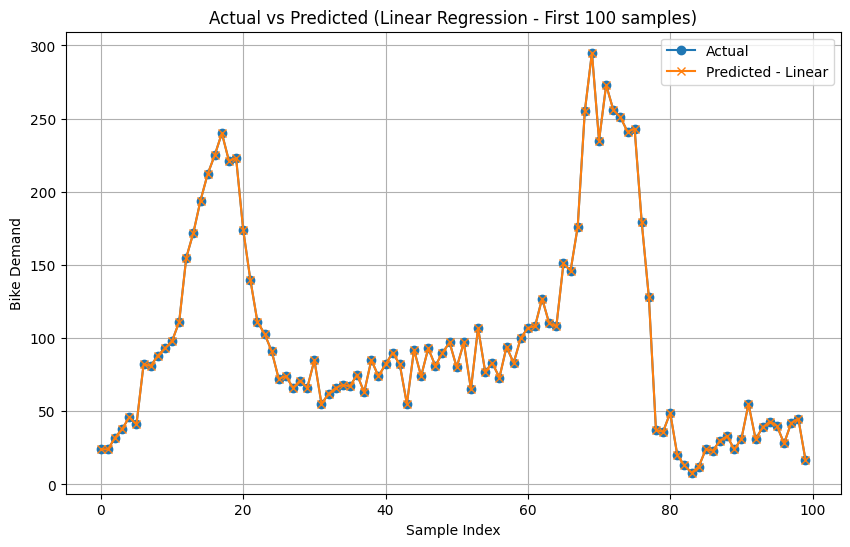


Sample Predictions:
        Actual  Predicted_Linear
126898      24              24.0
126899      24              24.0
126900      32              32.0
126901      38              38.0
126902      46              46.0

Summary of Model Performance:
Linear Regression - MSE: 3.6842849440771816e-27, MAE: 4.219136350012985e-14, R²: 1.0


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

split_point = int(len(bike_demand_per_10min) * 0.8)
train_data = bike_demand_per_10min[:split_point]
test_data = bike_demand_per_10min[split_point:]

# Calculate lag and rolling features ONLY on training data
train_data['Bike Demand Lag1'] = train_data['Bike Demand'].shift(1)
train_data['Bike Demand Lag2'] = train_data['Bike Demand'].shift(2)
train_data['Bike Demand RollingMean3'] = train_data['Bike Demand'].rolling(window=3).mean()
train_data.dropna(inplace=True)

# Apply the same transformations to the test data using ONLY past information
test_data['Bike Demand Lag1'] = test_data['Bike Demand'].shift(1)
test_data['Bike Demand Lag2'] = test_data['Bike Demand'].shift(2)
test_data['Bike Demand RollingMean3'] = test_data['Bike Demand'].rolling(window=3).mean()
test_data.dropna(inplace=True)

# Define features and target
features = ['Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1', 'Bike Demand Lag2', 'Bike Demand RollingMean3']
target = 'Bike Demand'

# Prepare training and testing sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 2. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R²: {r2}")
    return mse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear, mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# 3. Visualizations

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_linear[:100], label='Predicted - Linear', marker='x')
plt.title('Actual vs Predicted (Linear Regression - First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# 4. Save Results
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Linear': y_pred_linear
})
results.to_csv('predictions.csv', index=False)
print("\nSample Predictions:")
print(results.head())

# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"Linear Regression - MSE: {mse_linear}, MAE: {mae_linear}, R²: {r2_linear}")



### before addressed data leakage

First 5 rows of the dataset:
                     Duration            End date  Start station number  \
Start date                                                                
2016-01-01 00:06:58       166 2016-01-01 00:09:44                 31102   
2016-01-01 00:10:20       448 2016-01-01 00:17:48                 32039   
2016-01-01 00:13:52       715 2016-01-01 00:25:48                 31222   
2016-01-01 00:15:29       213 2016-01-01 00:19:03                 31506   
2016-01-01 00:16:16       872 2016-01-01 00:30:49                 31041   

                                        Start station  End station number  \
Start date                                                                  
2016-01-01 00:06:58               11th & Kenyon St NW               31105   
2016-01-01 00:10:20  Old Georgetown Rd & Southwick St               32002   
2016-01-01 00:13:52         New York Ave & 15th St NW               31214   
2016-01-01 00:15:29         1st & Rhode Island Ave NW       

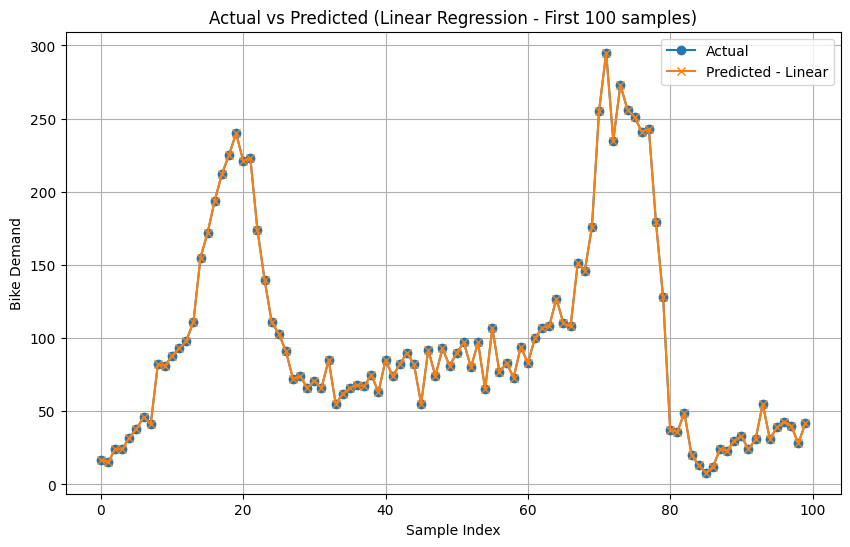


Sample Predictions:
        Actual  Predicted_Linear
126896      17              17.0
126897      15              15.0
126898      24              24.0
126899      24              24.0
126900      32              32.0

Summary of Model Performance:
Linear Regression - MSE: 2.4122347738409706e-25, MAE: 4.0514184237175103e-13, R²: 1.0


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing

# Display the first few rows
print("First 5 rows of the dataset:")
print(combined_df.head())

# Display column names
print("\nColumns in the dataset:")
print(combined_df.columns)

# Check for missing values
print("\nMissing values in each column:")
print(combined_df.isnull().sum())

# Convert 'Start date' to datetime - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
 combined_df['Start date'] = pd.to_datetime(combined_df['Start date'])

# Check the date range - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
 print(f"\nDate range: {combined_df['Start date'].min()} to {combined_df['Start date'].max()}")

# Set 'Start date' as the index for resampling - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
 combined_df.set_index('Start date', inplace=True)

# Feature Engineering
combined_df['Hour'] = combined_df.index.hour
combined_df['Minute'] = combined_df.index.minute
combined_df['DayOfWeek'] = combined_df.index.dayofweek
combined_df['IsWeekend'] = combined_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating data per 10-minute intervals
bike_demand_per_10min = combined_df.resample('10T').agg({
    'Duration': 'mean',
    'Hour': 'first',
    'Minute': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Start station number': 'first',
    'End station number': 'first',
    'Bike number': 'first',
    'Member type': 'first'
}).reset_index()

bike_demand_per_10min['Bike Demand'] = combined_df['Bike number'].resample('10T').count().reset_index(drop=True)

# Encoding categorical features
label_encoder = LabelEncoder()
bike_demand_per_10min['Bike number'] = label_encoder.fit_transform(bike_demand_per_10min['Bike number'].astype(str))
bike_demand_per_10min['Member type'] = label_encoder.fit_transform(bike_demand_per_10min['Member type'].astype(str))

# Lag and rolling mean features
bike_demand_per_10min['Bike Demand Lag1'] = bike_demand_per_10min['Bike Demand'].shift(1)
bike_demand_per_10min['Bike Demand Lag2'] = bike_demand_per_10min['Bike Demand'].shift(2)
bike_demand_per_10min['Bike Demand RollingMean3'] = bike_demand_per_10min['Bike Demand'].rolling(window=3).mean()
bike_demand_per_10min.dropna(inplace=True)

features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = bike_demand_per_10min[features]
y = bike_demand_per_10min[target]

# Splitting data into training and testing sets
split_point = int(len(bike_demand_per_10min) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"\nTraining Features: {X_train.shape}")
print(f"Testing Features: {X_test.shape}")


# 2. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R²: {r2}")
    return mse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear, mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# 3. Visualizations

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_linear[:100], label='Predicted - Linear', marker='x')
plt.title('Actual vs Predicted (Linear Regression - First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# 4. Save Results
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Linear': y_pred_linear
})
results.to_csv('predictions.csv', index=False)
print("\nSample Predictions:")
print(results.head())

# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"Linear Regression - MSE: {mse_linear}, MAE: {mae_linear}, R²: {r2_linear}")


## Machine Learning Algorithms - Stacked model (Random Forest + XGBoost)

### Simplified and addressed data leakage

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing

# Feature Engineering
combined_df['Hour'] = combined_df.index.hour
combined_df['Minute'] = combined_df.index.minute
combined_df['DayOfWeek'] = combined_df.index.dayofweek
combined_df['IsWeekend'] = combined_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating data per 10-minute intervals
bike_demand_per_10min = combined_df.resample('10T').agg({
    'Duration': 'mean',
    'Hour': 'first',
    'Minute': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Start station number': 'first',
    'End station number': 'first',
    'Bike number': 'first',
    'Member type': 'first'
}).reset_index()

bike_demand_per_10min['Bike Demand'] = combined_df['Bike number'].resample('10T').count().reset_index(drop=True)

# Encoding categorical features
label_encoder = LabelEncoder()
bike_demand_per_10min['Bike number'] = label_encoder.fit_transform(bike_demand_per_10min['Bike number'].astype(str))
bike_demand_per_10min['Member type'] = label_encoder.fit_transform(bike_demand_per_10min['Member type'].astype(str))

# 2. Split Data FIRST
split_point = int(len(bike_demand_per_10min) * 0.8)
train_data = bike_demand_per_10min[:split_point]
test_data = bike_demand_per_10min[split_point:]

# Calculate lag and rolling features ONLY on training data
train_data['Bike Demand Lag1'] = train_data['Bike Demand'].shift(1)
train_data['Bike Demand Lag2'] = train_data['Bike Demand'].shift(2)
train_data['Bike Demand RollingMean3'] = train_data['Bike Demand'].rolling(window=3).mean()
train_data.dropna(inplace=True)

# Apply the same transformations to the test data using ONLY past information
test_data['Bike Demand Lag1'] = test_data['Bike Demand'].shift(1)
test_data['Bike Demand Lag2'] = test_data['Bike Demand'].shift(2)
test_data['Bike Demand RollingMean3'] = test_data['Bike Demand'].rolling(window=3).mean()
test_data.dropna(inplace=True)

# Define features and target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

# Prepare training and testing sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"\nTraining Features: {X_train.shape}")
print(f"Testing Features: {X_test.shape}")

# 3. Model Training and Evaluation (Stacked Model Only)

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R²: {r2}")
    return mse, mae, r2

# Define and train the stacked model
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]
meta_model = Ridge()
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)
mse_stacked, mae_stacked, r2_stacked = evaluate_model(y_test, y_pred_stacked, "Stacked Model")

# 4. Visualizations (Stacked Model Only)
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_stacked[:100], label='Predicted - Stacked', marker='x')
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# 5. Save Results (Stacked Model Only)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Stacked': y_pred_stacked
})
results.to_csv('predictions.csv', index=False)
print("\nSample Predictions:")
print(results.head())

# 6. Summary of Model Performance (Stacked Model Only)
print("\nSummary of Model Performance:")
print(f"Stacked Model - MSE: {mse_stacked}, MAE: {mae_stacked}, R²: {r2_stacked}")

### before simplification and addresing data leakage

First 5 rows of the dataset:
                     Duration            End date  Start station number  \
Start date                                                                
2016-01-01 00:06:58       166 2016-01-01 00:09:44                 31102   
2016-01-01 00:10:20       448 2016-01-01 00:17:48                 32039   
2016-01-01 00:13:52       715 2016-01-01 00:25:48                 31222   
2016-01-01 00:15:29       213 2016-01-01 00:19:03                 31506   
2016-01-01 00:16:16       872 2016-01-01 00:30:49                 31041   

                                        Start station  End station number  \
Start date                                                                  
2016-01-01 00:06:58               11th & Kenyon St NW               31105   
2016-01-01 00:10:20  Old Georgetown Rd & Southwick St               32002   
2016-01-01 00:13:52         New York Ave & 15th St NW               31214   
2016-01-01 00:15:29         1st & Rhode Island Ave NW       

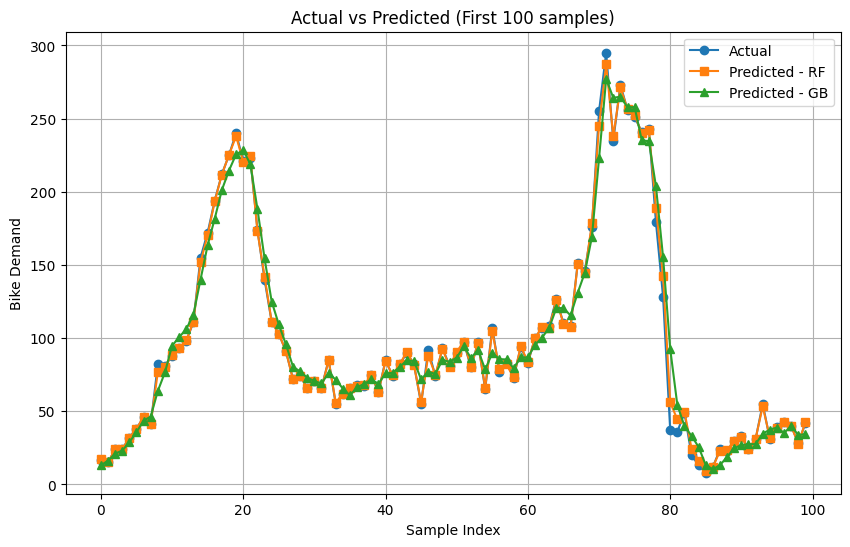


Sample Predictions:
        Actual  Predicted_RF  Predicted_GB
126896      17         17.22     13.101739
126897      15         15.02     16.225358
126898      24         24.07     21.062516
126899      24         24.11     23.122369
126900      32         31.65     28.841308

Summary of Model Performance:
Random Forest - MSE: 4.432590636171057, MAE: 0.8710277373229179, R²: 0.9990809774305354
Gradient Boosting - MSE: 65.78057376764012, MAE: 5.63005737409231, R²: 0.9863615125133645


In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing

# Convert 'Start date' to datetime - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
# combined_df['Start date'] = pd.to_datetime(combined_df['Start date'])

# Check the date range - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
# print(f"\nDate range: {combined_df['Start date'].min()} to {combined_df['Start date'].max()}")

# Set 'Start date' as the index for resampling - no need to because it's been done in the previous section, kept it in case this part needs to be run independently
# combined_df.set_index('Start date', inplace=True)

# Display the first few rows
print("First 5 rows of the dataset:")
print(combined_df.head())

# Display column names
print("\nColumns in the dataset:")
print(combined_df.columns)

# Check for missing values
print("\nMissing values in each column:")
print(combined_df.isnull().sum())

# Feature Engineering
combined_df['Hour'] = combined_df.index.hour
combined_df['Minute'] = combined_df.index.minute
combined_df['DayOfWeek'] = combined_df.index.dayofweek
combined_df['IsWeekend'] = combined_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating data per 10-minute intervals
bike_demand_per_10min = combined_df.resample('10T').agg({
    'Duration': 'mean',
    'Hour': 'first',
    'Minute': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Start station number': 'first',
    'End station number': 'first',
    'Bike number': 'first',
    'Member type': 'first'
}).reset_index()

bike_demand_per_10min['Bike Demand'] = combined_df['Bike number'].resample('10T').count().reset_index(drop=True)

# Encoding categorical features
label_encoder = LabelEncoder()
bike_demand_per_10min['Bike number'] = label_encoder.fit_transform(bike_demand_per_10min['Bike number'].astype(str))
bike_demand_per_10min['Member type'] = label_encoder.fit_transform(bike_demand_per_10min['Member type'].astype(str))

# Lag and rolling mean features
bike_demand_per_10min['Bike Demand Lag1'] = bike_demand_per_10min['Bike Demand'].shift(1)
bike_demand_per_10min['Bike Demand Lag2'] = bike_demand_per_10min['Bike Demand'].shift(2)
bike_demand_per_10min['Bike Demand RollingMean3'] = bike_demand_per_10min['Bike Demand'].rolling(window=3).mean()
bike_demand_per_10min.dropna(inplace=True)

features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = bike_demand_per_10min[features]
y = bike_demand_per_10min[target]

# Splitting data into training and testing sets
split_point = int(len(bike_demand_per_10min) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"\nTraining Features: {X_train.shape}")
print(f"Testing Features: {X_test.shape}")

# 2. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R²: {r2}")
    return mse, mae, r2

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb, mae_gb, r2_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# 3. Visualizations

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_rf[:100], label='Predicted - RF', marker='s')
plt.plot(y_pred_gb[:100], label='Predicted - GB', marker='^')
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# 4. Save Results
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_RF': y_pred_rf,
    'Predicted_GB': y_pred_gb
})
results.to_csv('predictions.csv', index=False)
print("\nSample Predictions:")
print(results.head())

# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}")
print(f"Gradient Boosting - MSE: {mse_gb}, MAE: {mae_gb}, R²: {r2_gb}")


Stacked Model - MSE: 1.9091082857441445e-11, MAE: 2.05222228238334e-06, R²: 0.999999999999996


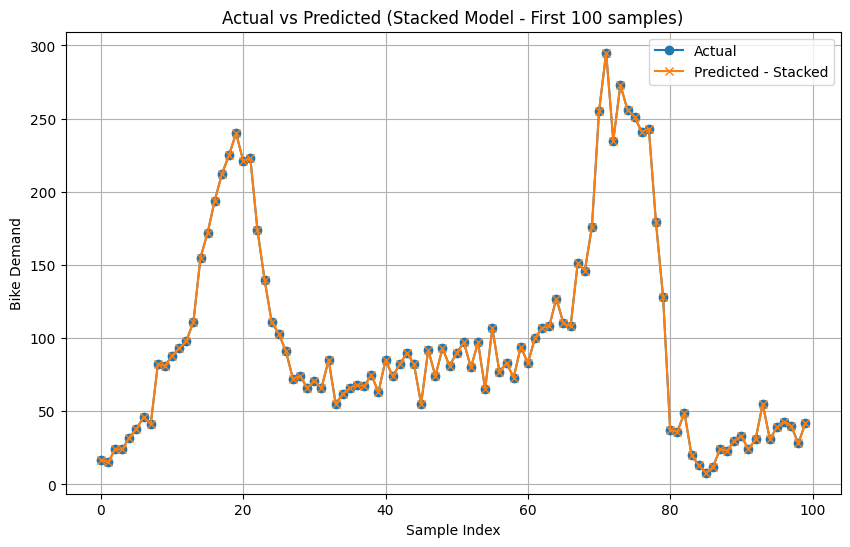


Summary of Model Performance:
Stacked Model - MSE: 1.9091082857441445e-11, MAE: 2.05222228238334e-06, R²: 0.999999999999996


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define base models
base_models = [
    ('linear', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

# Define the meta-model
meta_model = Ridge()

# Define the stacking model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Make predictions
y_pred_stacked = stacked_model.predict(X_test)

# Evaluate the stacked model
mse_stacked, mae_stacked, r2_stacked = evaluate_model(y_test, y_pred_stacked, "Stacked Model")

# Visualizations for Stacked Model
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_stacked[:100], label='Predicted - Stacked', marker='x')
plt.title('Actual vs Predicted (Stacked Model - First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"Stacked Model - MSE: {mse_stacked}, MAE: {mae_stacked}, R²: {r2_stacked}")


## Machine Learning Algorithms - Deep Learning

### addressing data leakage

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale features AFTER splitting the data (using only training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)        # Transform test data

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile and train
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\nTraining Long Short-Term Memory (LSTM) Model...")
lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_split=0.2,  # Uses last 20% of training data for validation (chronological)
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
mse_lstm, mae_lstm, r2_lstm = evaluate_dl_model(y_test, y_pred_lstm, "LSTM")

### before addressing data leakage


Training Long Short-Term Memory (LSTM) Model...
Epoch 1/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 2303.1501 - mae: 26.6971 - val_loss: 34.2147 - val_mae: 4.2755
Epoch 2/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 58.9644 - mae: 5.2187 - val_loss: 4.5021 - val_mae: 1.5842
Epoch 3/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 35.2868 - mae: 3.7129 - val_loss: 1.1751 - val_mae: 0.7834
Epoch 4/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 29.7115 - mae: 3.2942 - val_loss: 4.0487 - val_mae: 1.5340
Epoch 5/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 25.1557 - mae: 3.0559 - val_loss: 1.1409 - val_mae: 0.7870
Epoch 6/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 22.7418 - mae: 2.9438 - val_loss: 2.2258 - val_mae: 1.2077
Epoch 7/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 20.7633 - mae: 2.8676 - val_loss: 1.0647 - val_mae: 0.7969
Epoch 8/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 19.9287 - mae: 2.8493 - val_loss

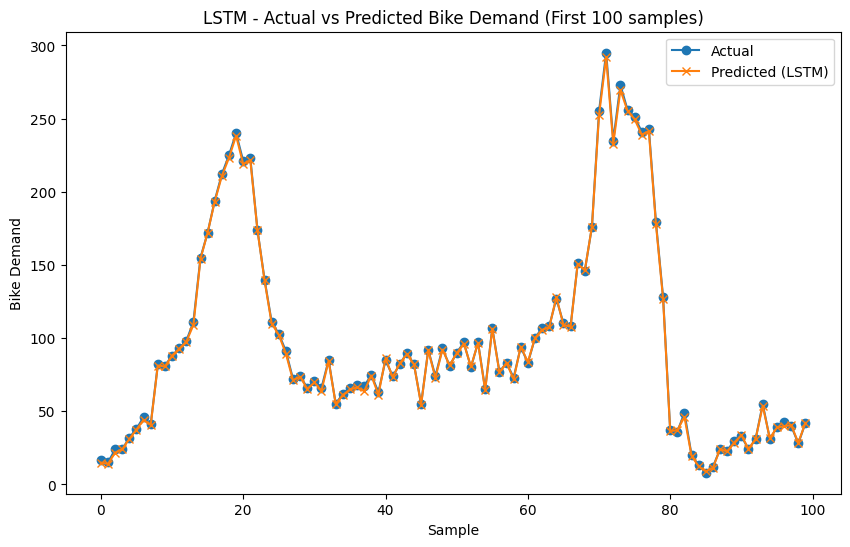


Summary of Deep Learning Model Performance:
LSTM - MSE: 1.4768409729003906, MAE: 0.9217178821563721, R²: 0.9996938109397888


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from sklearn.preprocessing import StandardScaler

# Scale the features for deep learning models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (3D format: samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)  # Adding a time step dimension
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Function to evaluate deep learning models
def evaluate_dl_model(y_true, y_pred, model_name="Deep Learning Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error (MSE): {mse}")
    print(f"{model_name} - Mean Absolute Error (MAE): {mae}")
    print(f"{model_name} - R-squared (R2): {r2}")
    return mse, mae, r2



### 1. Long Short-Term Memory (LSTM) Model

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the LSTM model
print("\nTraining Long Short-Term Memory (LSTM) Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Make predictions with the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
mse_lstm, mae_lstm, r2_lstm = evaluate_dl_model(y_test, y_pred_lstm, "Long Short-Term Memory (LSTM)")

### 2. Visualization

# Plot Actual vs Predicted for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_lstm[:100], label='Predicted (LSTM)', marker='x')
plt.title('LSTM - Actual vs Predicted Bike Demand (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Bike Demand')
plt.legend()
plt.show()

### 3. Summary of Results
print("\nSummary of Deep Learning Model Performance:")
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}, R²: {r2_lstm}")


## Save model for API


In [26]:
import tensorflow as tf

# Save the trained LSTM model
lstm_model.save("lstm_bike_demand_model.h5")


In [27]:
from google.colab import files
files.download("lstm_bike_demand_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Peak hours prediction for weekdays for top 10 station - New (LSTM)


Training Long Short-Term Memory (LSTM) Model...
Epoch 1/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 12075.5596 - mae: 82.3734 - val_loss: 519.3278 - val_mae: 17.6521 - learning_rate: 0.0010
Epoch 2/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 768.9974 - mae: 20.4497 - val_loss: 326.9375 - val_mae: 13.2530 - learning_rate: 0.0010
Epoch 3/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 620.1721 - mae: 17.5109 - val_loss: 241.5096 - val_mae: 11.2378 - learning_rate: 0.0010
Epoch 4/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 535.1478 - mae: 16.0624 - val_loss: 167.0620 - val_mae: 9.3546 - learning_rate: 0.0010
Epoch 5/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 464.7661 - mae: 14.8357 - val_loss: 104.9430 - val_mae: 7.3801 - learning_rate: 0.0010
Epoch 6/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 399.0094 - mae: 13.7396 - val_loss: 58.0260 - val_mae: 5.7356 - learning_rate: 0.0010
Epoch 7/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 359.6

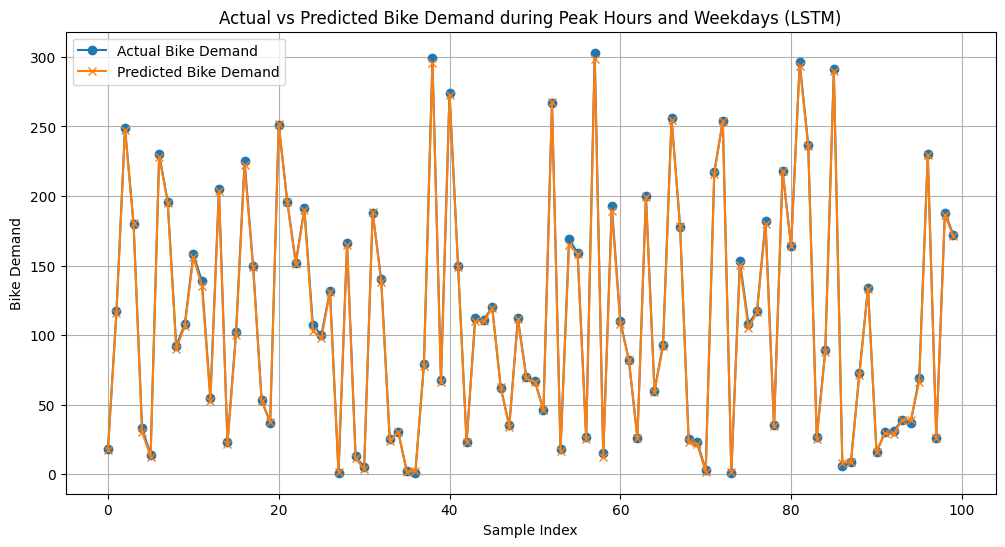


Sample Peak Hour and Weekday Predictions with Station Number:
        Start station number  Actual   Predicted  DayOfWeek  Peak Hour
95084                31103.0      18   17.162138        6.0        7.0
30490                31267.0     117  115.598213        5.0       17.0
134032               31241.0     249  247.775620        3.0       18.0
72686                31619.0     180  180.325668        4.0       18.0
59809                31241.0      33   30.273207        6.0        8.0
15454                31267.0      14   12.512485        6.0        7.0
87455                31506.0     230  228.344803        2.0        7.0
32361                31230.0     196  195.266876        4.0       17.0
107537               31230.0      92   90.240463        1.0       18.0
60870                31264.0     108  106.315643        6.0       17.0


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# 1. Define Peak Hours (e.g., 7-9 AM and 5-7 PM) and Weekdays (DayOfWeek = 0, 1, 2, 3, 4)
peak_hours = [7, 8, 17, 18]
weekday_days = [0, 1, 2, 3, 4]
top_10_stations = [31623, 31200, 31258, 31201, 31247, 31101, 31229, 31214, 31203, 31241]

# Filter data for peak hours, weekdays, and top 10 stations (allowing less than 10 if not all are present)
peak_hour_data = bike_demand_per_10min[
    (bike_demand_per_10min['Hour'].isin(peak_hours)) |
    (bike_demand_per_10min['DayOfWeek'].isin(weekday_days)) &
    (bike_demand_per_10min['Start station number'].isin(top_10_stations))
]

# Define features and target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = peak_hour_data[features]
y = peak_hour_data[target]

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scaling and Reshaping Data for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

# 4. LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the LSTM model
print("\nTraining Long Short-Term Memory (LSTM) Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Make predictions with the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
mse_lstm, mae_lstm, r2_lstm = evaluate_model(y_test, y_pred_lstm, "Long Short-Term Memory (LSTM)")

# 5. Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Bike Demand", marker="o")
plt.plot(y_pred_lstm[:100], label="Predicted Bike Demand", marker="x")
plt.title("Actual vs Predicted Bike Demand during Peak Hours and Weekdays (LSTM)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Demand")
plt.legend()
plt.grid()
plt.show()

# Add Start station number to the results
peak_hour_results = pd.DataFrame({
    'Start station number': X_test['Start station number'],
    'Actual': y_test,
    'Predicted': y_pred_lstm,
    'DayOfWeek': X_test['DayOfWeek'],  # Add DayOfWeek column
    'Peak Hour': X_test['Hour']        # Add Hour column as Peak Hour
})

# Save Predictions
peak_hour_results.to_csv('peak_hour_predictions.csv', index=False)
print("\nSample Peak Hour and Weekday Predictions with Station Number:")
print(peak_hour_results.head(10))


## All stations peak hours on weekdays bike demand prediction vs historical

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Define Peak Hours, Weekday Days, and Stations
peak_hours = [7, 8, 17, 18]
weekday_days = [0, 1, 2, 3, 4]
stations = peak_hour_data['Start station number'].unique()
peak_hour_data = peak_hour_data[peak_hour_data['Start station number'].isin(stations)]


# Filter data for peak hours and all unique stations
peak_hour_data = bike_demand_per_10min[
    (bike_demand_per_10min['Hour'].isin(peak_hours)) &
    (bike_demand_per_10min['DayOfWeek'].isin(weekday_days))  # No need for Start station filter here
]

# Define Features and Target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = peak_hour_data[features]
y = peak_hour_data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features and Reshape for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Define LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the Model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the Model
print("\nTraining LSTM Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Predict on Test Data
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Create Results DataFrame
peak_hour_results = pd.DataFrame({
    'Start station number': X_test['Start station number'].values,
    'Actual': y_test.values,
    'Predicted': y_pred_lstm,
    'DayOfWeek': X_test['DayOfWeek'].values,
    'Peak Hour': X_test['Hour'].values
})

# Group by Station and Peak Hour to Aggregate Bike Demand
grouped_results = peak_hour_results.groupby(
    ['Start station number', 'DayOfWeek', 'Peak Hour']
).agg({'Actual': 'sum', 'Predicted': 'sum'}).reset_index()

# Save Results
grouped_results.to_csv('grouped_peak_hour_demand.csv', index=False)

# For Google Colab: Download the CSV file
from google.colab import files
files.download('grouped_peak_hour_demand.csv')

# Display All Results
print("\nComplete Aggregated Bike Demand for All Unique Stations:")
print(grouped_results)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# Create a complete grid of all combinations for weekdays
stations = bike_demand_per_10min['Start station number'].unique()
weekday_days = [0, 1, 2, 3, 4]  # Explicitly defining weekdays (Monday to Friday)
peak_hours = [7, 8, 17, 18]  # Peak hours for weekdays

# Create a dataframe with all combinations of stations, weekdays, and peak hours
from itertools import product
complete_combinations = pd.DataFrame(list(product(stations, weekday_days, peak_hours)),
                                     columns=['Start station number', 'DayOfWeek', 'Peak Hour'])

# Ensure grouped_results only contains weekdays before merging
grouped_results = grouped_results[grouped_results['DayOfWeek'].isin(weekday_days)]

# Merge the complete combinations with the grouped results
grouped_results = complete_combinations.merge(
    grouped_results,
    on=['Start station number', 'DayOfWeek', 'Peak Hour'],
    how='left'
)

# Fill missing values (e.g., assume 0 demand for missing combinations)
grouped_results['Actual'] = grouped_results['Actual'].fillna(0)
grouped_results['Predicted'] = grouped_results['Predicted'].fillna(0)

# Save the updated results
grouped_results.to_csv('grouped_weekday_peak_hour_demand.csv', index=False)

# For Google Colab: Download the CSV file
from google.colab import files
files.download('grouped_weekday_peak_hour_demand.csv')

# Display All Results
print("\nComplete Aggregated Bike Demand for Weekdays and Peak Hours:")
print(grouped_results)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Complete Aggregated Bike Demand for Weekdays and Peak Hours:
       Start station number  DayOfWeek  Peak Hour  Actual  Predicted
0                   31041.0          0          7     0.0        0.0
1                   31041.0          0          8     0.0        0.0
2                   31041.0          0         17     0.0        0.0
3                   31041.0          0         18     0.0        0.0
4                   31041.0          1          7     0.0        0.0
...                     ...        ...        ...     ...        ...
10435               32406.0          3         18     0.0        0.0
10436               32406.0          4          7     0.0        0.0
10437               32406.0          4          8     0.0        0.0
10438               32406.0          4         17     0.0        0.0
10439               32406.0          4         18     0.0        0.0

[10440 rows x 5 columns]


## All stations peak hours on weekend bike demand prediction vs historical

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Define Peak Hours and Weekend Days
peak_hours = [10, 11, 12, 13, 14]
weekend_days = [5, 6]

# Filter data for peak hours and weekends only
weekend_data = bike_demand_per_10min[
    (bike_demand_per_10min['Hour'].isin(peak_hours)) &
    (bike_demand_per_10min['DayOfWeek'].isin(weekend_days))
]

# Define unique stations based on weekend data only
stations_weekend = weekend_data['Start station number'].unique()

# Apply the filtered stations back to the dataset
weekend_data = weekend_data[weekend_data['Start station number'].isin(stations_weekend)]

# Define Features and Target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = weekend_data[features]
y = weekend_data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features and Reshape for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Define LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the Model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the Model
print("\nTraining LSTM Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Predict on Test Data
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Create Results DataFrame
peak_hour_results = pd.DataFrame({
    'Start station number': X_test['Start station number'].values,
    'Actual': y_test.values,
    'Predicted': y_pred_lstm,
    'DayOfWeek': X_test['DayOfWeek'].values,
    'Peak Hour': X_test['Hour'].values
})

# Group by Station and Peak Hour to Aggregate Bike Demand
grouped_results = peak_hour_results.groupby(
    ['Start station number', 'DayOfWeek', 'Peak Hour']
).agg({'Actual': 'sum', 'Predicted': 'sum'}).reset_index()

# Save Results
grouped_results.to_csv('grouped_peak_hour_demand.csv', index=False)

# For Google Colab: Download the CSV file
from google.colab import files
files.download('grouped_peak_hour_demand.csv')

# Display All Results
print("\nComplete Aggregated Bike Demand for All Unique Stations:")
print(grouped_results)



Training LSTM Model...
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 17712.7617 - mae: 119.0607 - val_loss: 9425.4385 - val_mae: 91.1103 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5928.2661 - mae: 69.2116 - val_loss: 2335.3513 - val_mae: 40.1797 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2048.0222 - mae: 38.4541 - val_loss: 577.4017 - val_mae: 19.3883 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 678.4552 - mae: 20.4191 - val_loss: 359.8940 - val_mae: 14.8879 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 566.4603 - mae: 18.5813 - val_loss: 319.5736 - val_mae: 14.1145 - learning_rate: 0.0010
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 557.0469 - mae: 18.2355 - val_loss: 293.0107 - val_mae: 13.4750 - learning_rate: 0.0010
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 516.6763 - mae: 17.63

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Complete Aggregated Bike Demand for All Unique Stations:
      Start station number  DayOfWeek  Peak Hour  Actual   Predicted
0                  31000.0        5.0       13.0      98   92.469498
1                  31000.0        6.0       10.0     117  100.168297
2                  31002.0        5.0       10.0      62   61.488319
3                  31002.0        6.0       13.0     226  212.746719
4                  31002.0        6.0       14.0     199  206.651123
...                    ...        ...        ...     ...         ...
1194               32055.0        5.0       13.0     181  181.697968
1195               32061.0        5.0       12.0     232  217.952438
1196               32083.0        5.0       10.0       8   20.444172
1197               32205.0        6.0       11.0     168  158.330185
1198               32218.0        5.0       12.0     218  204.481354

[1199 rows x 5 columns]


In [37]:
# Create a complete grid of all combinations for weekends
stations = bike_demand_per_10min['Start station number'].unique()
weekend_days = [5, 6]  # Only Saturday and Sunday
peak_hours = list(range(10, 15))  # Peak hours from 10 AM to 2 PM

# Create a dataframe with all combinations of stations, weekends, and peak hours
from itertools import product
complete_combinations = pd.DataFrame(list(product(stations, weekend_days, peak_hours)),
                                     columns=['Start station number', 'DayOfWeek', 'Peak Hour'])

# Ensure grouped_results only contains weekends before merging
grouped_results = grouped_results[grouped_results['DayOfWeek'].isin(weekend_days)]

# Merge the complete combinations with the grouped results
grouped_results = complete_combinations.merge(
    grouped_results,
    on=['Start station number', 'DayOfWeek', 'Peak Hour'],
    how='left'
)

# Fill missing values (e.g., assume 0 demand for missing combinations)
grouped_results['Actual'] = grouped_results['Actual'].fillna(0)
grouped_results['Predicted'] = grouped_results['Predicted'].fillna(0)

# Save the updated results
grouped_results.to_csv('grouped_weekend_peak_hour_demand.csv', index=False)

# For Google Colab: Download the CSV file
from google.colab import files
files.download('grouped_weekend_peak_hour_demand.csv')

# Display All Results
print("\nComplete Aggregated Bike Demand for Weekends and Peak Hours (10-14):")
print(grouped_results)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Complete Aggregated Bike Demand for Weekends and Peak Hours (10-14):
      Start station number  DayOfWeek  Peak Hour  Actual  Predicted
0                  31041.0          5         10     0.0        0.0
1                  31041.0          5         11     0.0        0.0
2                  31041.0          5         12     0.0        0.0
3                  31041.0          5         13     0.0        0.0
4                  31041.0          5         14     0.0        0.0
...                    ...        ...        ...     ...        ...
5215               32406.0          6         10     0.0        0.0
5216               32406.0          6         11     0.0        0.0
5217               32406.0          6         12     0.0        0.0
5218               32406.0          6         13     0.0        0.0
5219               32406.0          6         14     0.0        0.0

[5220 rows x 5 columns]


## Below are the original code, no longer useful but serve a draft purpose

## FCNN + LSTM


Training Fully Connected Neural Network (FCNN)...
Epoch 1/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1132.5295 - mae: 18.3651 - val_loss: 12.0363 - val_mae: 2.6151
Epoch 2/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 88.7714 - mae: 6.2043 - val_loss: 2.8784 - val_mae: 1.2331
Epoch 3/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 68.3469 - mae: 5.2419 - val_loss: 14.8090 - val_mae: 2.6511
Epoch 4/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 58.3036 - mae: 4.8407 - val_loss: 82.0046 - val_mae: 5.5155
Epoch 5/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 47.2499 - mae: 4.3176 - val_loss: 32.0954 - val_mae: 3.7197
Epoch 6/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 34.6479 - mae: 3.6805 - val_loss: 71.3712 - val_mae: 5.2668
Epoch 7/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 27.6928 - mae: 3.2890 - val_loss: 88.7080 - val_mae: 5.5136
Epoch 8/20
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 23.7529 - mae: 3.0881 - v

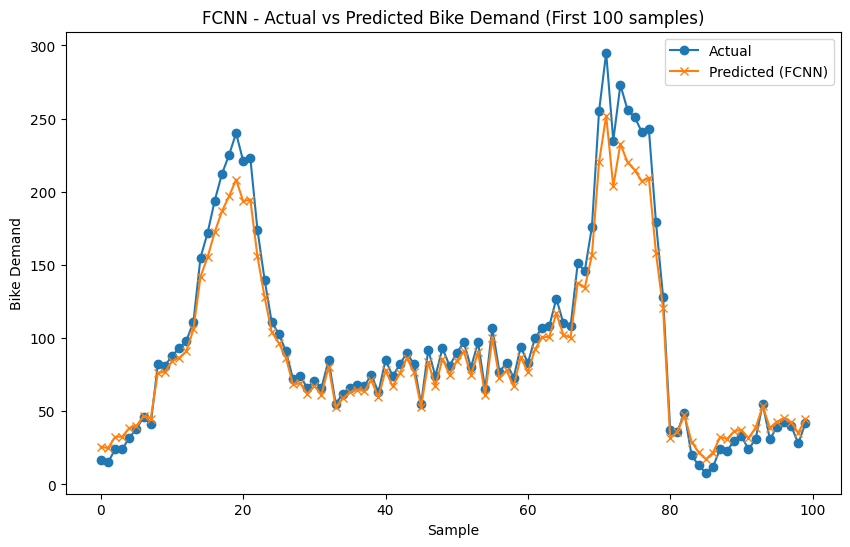

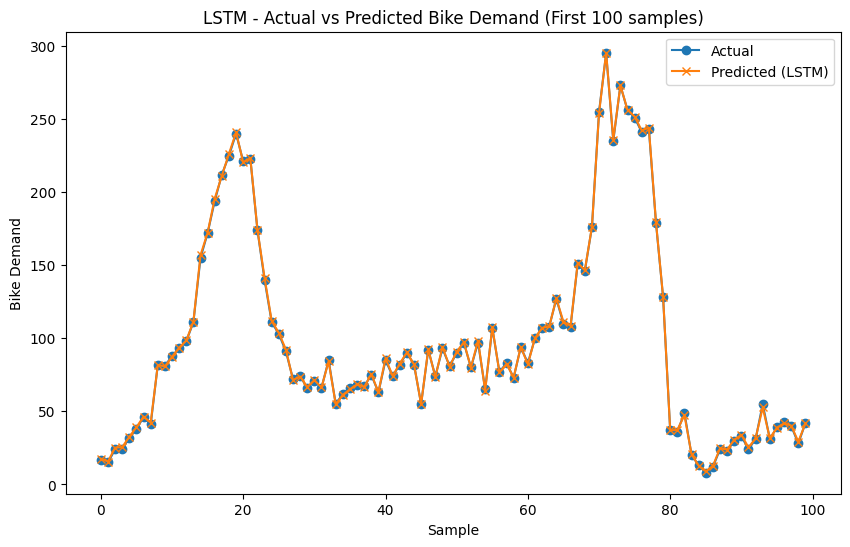


Summary of Deep Learning Model Performance:
FCNN - MSE: 147.68560791015625, MAE: 9.269002914428711, R²: 0.9693799018859863
LSTM - MSE: 1.027099847793579, MAE: 0.8393147587776184, R²: 0.9997870326042175


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from sklearn.preprocessing import StandardScaler

# Scale the features for deep learning models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (3D format: samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)  # Adding a time step dimension
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Function to evaluate deep learning models
def evaluate_dl_model(y_true, y_pred, model_name="Deep Learning Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error (MSE): {mse}")
    print(f"{model_name} - Mean Absolute Error (MAE): {mae}")
    print(f"{model_name} - R-squared (R2): {r2}")
    return mse, mae, r2

### 1. Fully Connected Neural Network (FCNN)

# Define the FCNN model
fcnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
fcnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the FCNN model
print("\nTraining Fully Connected Neural Network (FCNN)...")
fcnn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Make predictions with the FCNN model
y_pred_fcnn = fcnn_model.predict(X_test_scaled).flatten()
mse_fcnn, mae_fcnn, r2_fcnn = evaluate_dl_model(y_test, y_pred_fcnn, "Fully Connected Neural Network (FCNN)")

### 2. Long Short-Term Memory (LSTM) Model

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the LSTM model
print("\nTraining Long Short-Term Memory (LSTM) Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Make predictions with the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
mse_lstm, mae_lstm, r2_lstm = evaluate_dl_model(y_test, y_pred_lstm, "Long Short-Term Memory (LSTM)")

### Visualization

# Plot Actual vs Predicted for FCNN
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_fcnn[:100], label='Predicted (FCNN)', marker='x')
plt.title('FCNN - Actual vs Predicted Bike Demand (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Bike Demand')
plt.legend()
plt.show()

# Plot Actual vs Predicted for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_lstm[:100], label='Predicted (LSTM)', marker='x')
plt.title('LSTM - Actual vs Predicted Bike Demand (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Bike Demand')
plt.legend()
plt.show()

### Summary of Results
print("\nSummary of Deep Learning Model Performance:")
print(f"FCNN - MSE: {mse_fcnn}, MAE: {mae_fcnn}, R²: {r2_fcnn}")
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}, R²: {r2_lstm}")


## Machine Learning Algorithms, Linear Regression, RandomForest and Gradient Boosting

First 5 rows of the dataset:
                     Duration            End date  Start station number  \
Start date                                                                
2016-01-01 00:06:58       166 2016-01-01 00:09:44                 31102   
2016-01-01 00:10:20       448 2016-01-01 00:17:48                 32039   
2016-01-01 00:13:52       715 2016-01-01 00:25:48                 31222   
2016-01-01 00:15:29       213 2016-01-01 00:19:03                 31506   
2016-01-01 00:16:16       872 2016-01-01 00:30:49                 31041   

                                        Start station  End station number  \
Start date                                                                  
2016-01-01 00:06:58               11th & Kenyon St NW               31105   
2016-01-01 00:10:20  Old Georgetown Rd & Southwick St               32002   
2016-01-01 00:13:52         New York Ave & 15th St NW               31214   
2016-01-01 00:15:29         1st & Rhode Island Ave NW       

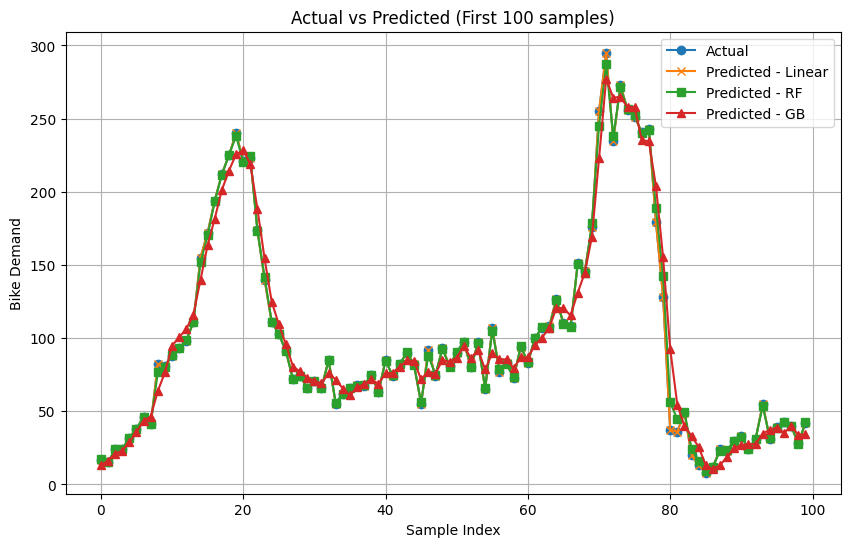


Sample Predictions:
        Actual  Predicted_Linear  Predicted_RF  Predicted_GB
126896      17              17.0         17.22     13.101739
126897      15              15.0         15.02     16.225358
126898      24              24.0         24.07     21.062516
126899      24              24.0         24.11     23.122369
126900      32              32.0         31.65     28.841308

Summary of Model Performance:
Linear Regression - MSE: 2.4122347738409706e-25, MAE: 4.0514184237175103e-13, R²: 1.0
Random Forest - MSE: 4.432590636171057, MAE: 0.8710277373229179, R²: 0.9990809774305354
Gradient Boosting - MSE: 65.78057376764013, MAE: 5.6300573740923125, R²: 0.9863615125133645


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing

# Display the first few rows
print("First 5 rows of the dataset:")
print(combined_df.head())

# Display column names
print("\nColumns in the dataset:")
print(combined_df.columns)

# Check for missing values
print("\nMissing values in each column:")
print(combined_df.isnull().sum())

# Convert 'Start date' to datetime
# combined_df['Start date'] = pd.to_datetime(combined_df['Start date'])

# Check the date range
# print(f"\nDate range: {combined_df['Start date'].min()} to {combined_df['Start date'].max()}")

# Set 'Start date' as the index for resampling
# combined_df.set_index('Start date', inplace=True)

# Feature Engineering
combined_df['Hour'] = combined_df.index.hour
combined_df['Minute'] = combined_df.index.minute
combined_df['DayOfWeek'] = combined_df.index.dayofweek
combined_df['IsWeekend'] = combined_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Aggregating data per 10-minute intervals
bike_demand_per_10min = combined_df.resample('10T').agg({
    'Duration': 'mean',
    'Hour': 'first',
    'Minute': 'first',
    'DayOfWeek': 'first',
    'IsWeekend': 'first',
    'Start station number': 'first',
    'End station number': 'first',
    'Bike number': 'first',
    'Member type': 'first'
}).reset_index()

bike_demand_per_10min['Bike Demand'] = combined_df['Bike number'].resample('10T').count().reset_index(drop=True)

# Encoding categorical features
label_encoder = LabelEncoder()
bike_demand_per_10min['Bike number'] = label_encoder.fit_transform(bike_demand_per_10min['Bike number'].astype(str))
bike_demand_per_10min['Member type'] = label_encoder.fit_transform(bike_demand_per_10min['Member type'].astype(str))

# Lag and rolling mean features
bike_demand_per_10min['Bike Demand Lag1'] = bike_demand_per_10min['Bike Demand'].shift(1)
bike_demand_per_10min['Bike Demand Lag2'] = bike_demand_per_10min['Bike Demand'].shift(2)
bike_demand_per_10min['Bike Demand RollingMean3'] = bike_demand_per_10min['Bike Demand'].rolling(window=3).mean()
bike_demand_per_10min.dropna(inplace=True)

features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = bike_demand_per_10min[features]
y = bike_demand_per_10min[target]

# Splitting data into training and testing sets
split_point = int(len(bike_demand_per_10min) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"\nTraining Features: {X_train.shape}")
print(f"Testing Features: {X_test.shape}")

# 2. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R²: {r2}")
    return mse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear, mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb, mae_gb, r2_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# 3. Visualizations

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred_linear[:100], label='Predicted - Linear', marker='x')
plt.plot(y_pred_rf[:100], label='Predicted - RF', marker='s')
plt.plot(y_pred_gb[:100], label='Predicted - GB', marker='^')
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Bike Demand')
plt.legend()
plt.grid()
plt.show()

# 4. Save Results
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Linear': y_pred_linear,
    'Predicted_RF': y_pred_rf,
    'Predicted_GB': y_pred_gb
})
results.to_csv('predictions.csv', index=False)
print("\nSample Predictions:")
print(results.head())

# Summary of Model Performance
print("\nSummary of Model Performance:")
print(f"Linear Regression - MSE: {mse_linear}, MAE: {mae_linear}, R²: {r2_linear}")
print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}")
print(f"Gradient Boosting - MSE: {mse_gb}, MAE: {mae_gb}, R²: {r2_gb}")


## Peak hours prediction for weekdays for top 10 station - original (linear regression)

In [ ]:
print(bike_demand_per_10min.columns)


Index(['Start date', 'Duration', 'Hour', 'Minute', 'DayOfWeek', 'IsWeekend',
       'Start station number', 'End station number', 'Bike number',
       'Member type', 'Bike Demand', 'Bike Demand Lag1', 'Bike Demand Lag2',
       'Bike Demand RollingMean3'],
      dtype='object')


In [ ]:
# Ensure 'Start station number' is treated as an integer, removing any decimals
bike_demand_per_10min['Start station number'] = bike_demand_per_10min['Start station number'].astype(float).round().astype(int)


In [ ]:
# The count of occurrences for each Start station number and show the top 10.
top_stations_count = bike_demand_per_10min['Start station number'].value_counts().head(10)
top_stations_count

,count
Start station number,
31623,2591
31200,2268
31258,2003
31201,1974
31247,1749
31101,1740
31229,1707
31214,1615
31203,1585


Linear Regression - MSE: 0.00, MAE: 0.00, R²: 1.00


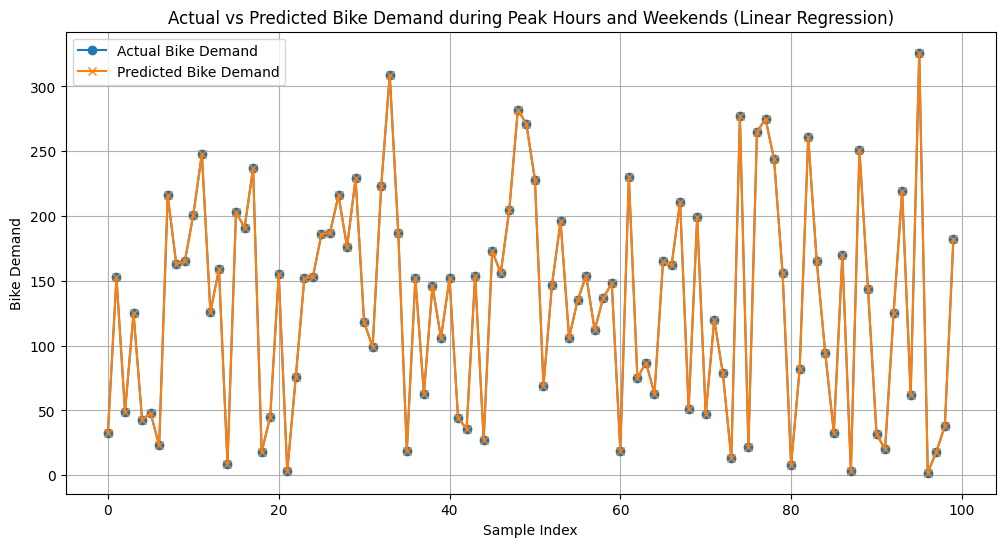


Sample Peak Hour and Weekend Predictions with Station Number:
        Start station number  Actual  Predicted  DayOfWeek  Peak Hour
399                    31265      33       33.0        6.0       18.0
100272                 31295     153      153.0        0.0        8.0
56702                  31623      49       49.0        5.0       18.0
114960                 31312     125      125.0        4.0        8.0
88896                  31203      43       43.0        5.0        8.0
10274                  31223      48       48.0        5.0        8.0
39504                  31121      23       23.0        5.0        8.0
129564                 31274     216      216.0        0.0       18.0
60095                  31080     163      163.0        1.0        7.0
43887                  31249     165      165.0        0.0       18.0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define Peak Hours (e.g., 7-9 AM and 5-7 PM) and Weekends (DayOfWeek = 5, 6)
peak_hours = [7, 8, 17, 18]
weekend_days = [5, 6]
top_10_stations = [31623, 31200, 31258, 31201, 31247, 31101, 31229, 31214, 31203, 31241]

# Filter data for peak hours, weekends, and top 10 stations (allowing less than 10 if not all are present)
peak_hour_data = bike_demand_per_10min[
    (bike_demand_per_10min['Hour'].isin(peak_hours)) |
    (bike_demand_per_10min['DayOfWeek'].isin(weekend_days)) &
    (bike_demand_per_10min['Start station number'].isin(top_10_stations))
]

# Define features and target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = peak_hour_data[features]
y = peak_hour_data[target]

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear, mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# 4. Predict Bike Demand at Peak Hours and Weekends
peak_hour_predictions = linear_model.predict(X_test)

# 5. Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Bike Demand", marker="o")
plt.plot(peak_hour_predictions[:100], label="Predicted Bike Demand", marker="x")
plt.title("Actual vs Predicted Bike Demand during Peak Hours and Weekends (Linear Regression)")
plt.xlabel("Sample Index")
plt.ylabel("Bike Demand")
plt.legend()
plt.grid()
plt.show()

# Add Start station number to the results
peak_hour_results = pd.DataFrame({
    'Start station number': X_test['Start station number'],
    'Actual': y_test,
    'Predicted': peak_hour_predictions,
    'DayOfWeek': X_test['DayOfWeek'],  # Add DayOfWeek column
    'Peak Hour': X_test['Hour']        # Add Hour column as Peak Hour
})

# Save Predictions
peak_hour_results.to_csv('peak_hour_predictions.csv', index=False)
print("\nSample Peak Hour and Weekend Predictions with Station Number:")
print(peak_hour_results.head(10))


## Unique value


In [ ]:
unique_values_count = bike_demand_per_10min['Start station number'].nunique()
print(f"The number of unique values in 'Start station number' is: {unique_values_count}")

The number of unique values in 'Start station number' is: 522


## Every peak hour, every day, top 10 stations

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Define Peak Hours and Top 10 Stations
peak_hours = [7, 8, 17, 18]
weekend_days = [5, 6]
top_10_stations = [31623, 31200, 31258, 31201, 31247, 31101, 31229, 31214, 31203, 31241]

# Filter data for peak hours and top 10 stations
peak_hour_data = bike_demand_per_10min[
    (bike_demand_per_10min['Hour'].isin(peak_hours)) &
    (bike_demand_per_10min['Start station number'].isin(top_10_stations))
]

# Define Features and Target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = peak_hour_data[features]
y = peak_hour_data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features and Reshape for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = np.expand_dims(X_train_scaled, axis=1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=1)

# Define LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the Model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the Model
print("\nTraining LSTM Model...")
lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1, callbacks=[lr_scheduler])

# Predict on Test Data
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Create Results DataFrame
peak_hour_results = pd.DataFrame({
    'Start station number': X_test['Start station number'].values,
    'Actual': y_test.values,
    'Predicted': y_pred_lstm,
    'DayOfWeek': X_test['DayOfWeek'].values,
    'Peak Hour': X_test['Hour'].values
})

# Group by Station and Peak Hour to Aggregate Bike Demand
grouped_results = peak_hour_results.groupby(
    ['Start station number', 'DayOfWeek', 'Peak Hour']
).agg({'Actual': 'sum', 'Predicted': 'sum'}).reset_index()

# Save Results
grouped_results.to_csv('grouped_peak_hour_demand.csv', index=False)
from google.colab import files
files.download('grouped_peak_hour_demand.csv')

# Display All Results
print("\nComplete Aggregated Bike Demand for Top 10 Stations:")
print(grouped_results)



## Peak Hours Prediction

Linear Regression - MSE: 0.00, MAE: 0.00, R²: 1.00
Random Forest - MSE: 15.96, MAE: 2.49, R²: 1.00
Gradient Boosting - MSE: 103.12, MAE: 7.61, R²: 0.99

Best Model: Linear Regression


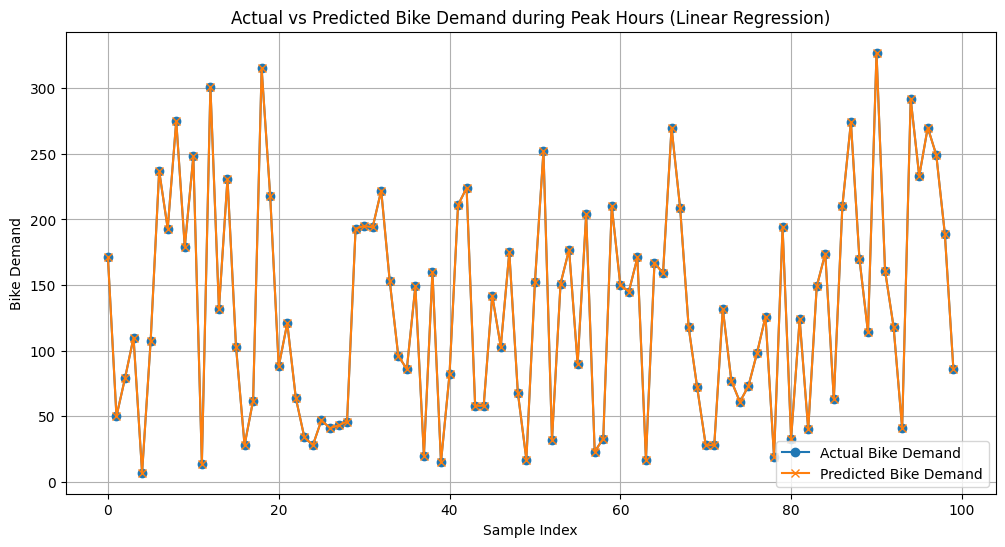


Sample Peak Hour Predictions:
        Actual  Predicted
15516      171      171.0
45403       50       50.0
131658      79       79.0
54046      110      110.0
157578       7        7.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# 1. Define Peak Hours (e.g., 7-9 AM and 5-7 PM)
peak_hours = [7, 8, 17, 18]

# Filter data for peak hours
peak_hour_data = bike_demand_per_10min[bike_demand_per_10min['Hour'].isin(peak_hours)]

# Define features and target
features = [
    'Hour', 'Minute', 'DayOfWeek', 'IsWeekend', 'Bike Demand Lag1',
    'Bike Demand Lag2', 'Bike Demand RollingMean3', 'Start station number',
    'End station number', 'Bike number', 'Member type'
]
target = 'Bike Demand'

X = peak_hour_data[features]
y = peak_hour_data[target]

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Training and Evaluation

def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear, mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb, mae_gb, r2_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# Select Best Model
model_performance = {
    "Linear Regression": mse_linear,
    "Random Forest": mse_rf,
    "Gradient Boosting": mse_gb
}
best_model_name = min(model_performance, key=model_performance.get)
print(f"\nBest Model: {best_model_name}")

# Train the best model on the full dataset
if best_model_name == "Linear Regression":
    best_model = LinearRegression()
elif best_model_name == "Random Forest":
    best_model = RandomForestRegressor(n_estimators=100, random_state=42)
else:
    best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

best_model.fit(X, y)

# 4. Predict Bike Demand at Peak Hours
peak_hour_predictions = best_model.predict(X_test)

# 5. Visualization of Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual Bike Demand", marker="o")
plt.plot(peak_hour_predictions[:100], label="Predicted Bike Demand", marker="x")
plt.title(f"Actual vs Predicted Bike Demand during Peak Hours ({best_model_name})")
plt.xlabel("Sample Index")
plt.ylabel("Bike Demand")
plt.legend()
plt.grid()
plt.show()

# Save Predictions
peak_hour_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': peak_hour_predictions
})
peak_hour_results.to_csv('peak_hour_predictions.csv', index=False)
print("\nSample Peak Hour Predictions:")
print(peak_hour_results.head())
